In [2]:
import os
import pandas as pd
import seaborn as sns

In [89]:
import models.logic_inference as logic_inference

In [90]:
import argparse

In [91]:
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--dataset_name', type=str, default="ProntoQA")
    parser.add_argument('--split', type=str, default='train')
    parser.add_argument('--train_model_name', type=str, default="trl-internal-testing/tiny-random-LlamaForCausalLM")
    parser.add_argument('--model_path', type=str, default='/mnt/evafs/groups/luckner-lab/models/')
    parser.add_argument('--use_fine_tuned', type=int, default=1)
    parser.add_argument('--resume_from_checkpoint', type=str, default="no")
    parser.add_argument('--demonstration_path', type=str, default='./models/prompts')
    parser.add_argument('--result_path', type=str, default="/mnt/evafs/groups/luckner-lab/models/")
    parser.add_argument('--batch_size', type=int, default=32)
    parser.add_argument('--mini_batch_size', type=int, default=1)
    parser.add_argument('--gradient_accumulation_steps', type=int, default=4)
    parser.add_argument('--ppo_epochs', type=int, default=4)
    parser.add_argument('--learning_rate', type=float, default=1e-5)
    parser.add_argument('--epochs', type=int, default=1)
    parser.add_argument('--use_ada', type=int, default=0)
    parser.add_argument('--load_in_8bit', type=int, default=1)
    parser.add_argument('--lora_r', type=int, default=16)
    parser.add_argument('--num_beams', type=int, default=1)
    parser.add_argument('--num_return_sequences', type=int, default=1)
    args, unknown = parser.parse_known_args()
    return args

In [92]:
args = parse_args()

In [93]:
# prepare logic engine
args.model_name = args.train_model_name
args.save_path = "./outputs/logic_inference"
args.backup_strategy = 'Random'
args.backup_LLM_result_path = ''
args.refiment = -1
args.mode = "CoT"
logic_engine = logic_inference.LogicInferenceEngine(args)

In [ ]:
logic_engine.inference_on_text(batch["response"])

In [ ]:
    "id": "logical_deduction_172",
    "context": "The following paragraphs each describe a set of seven objects arranged in a fixed order. The statements are logically consistent within each paragraph.\n\nIn an antique car show, there are seven vehicles: a limousine, a convertible, a station wagon, a minivan, a bus, a tractor, and a truck. The minivan is the oldest. The truck is older than the station wagon. The truck is newer than the limousine. The bus is newer than the convertible. The bus is older than the tractor. The limousine is newer than the tractor.",
    "question": "Which of the following is true?",
    "answer": "A",
    "program": "Domain:\n1: oldest\n7: newest\nVariables:\nlimousine [IN] [1, 2, 3, 4, 5, 6, 7]\nconvertible [IN] [1, 2, 3, 4, 5, 6, 7]\nstation_wagon [IN] [1, 2, 3, 4, 5, 6, 7]\nminivan [IN] [1, 2, 3, 4, 5, 6, 7]\nbus [IN] [1, 2, 3, 4, 5, 6, 7]\ntractor [IN] [1, 2, 3, 4, 5, 6, 7]\ntruck [IN] [1, 2, 3, 4, 5, 6, 7]\nConstraints:\nminivan == 1 ::: The minivan is the oldest.\ntruck > station_wagon ::: The truck is older than the station wagon.\ntruck < limousine ::: The truck is newer than the limousine.\nbus > convertible ::: The bus is newer than the convertible.\nbus < tractor ::: The bus is older than the tractor.\nlimousine < tractor ::: The limousine is newer than the tractor.\nAllDifferentConstraint([limousine, convertible, station_wagon, minivan, bus, tractor, truck]) ::: All vehicles have different values.\nQuery:\nA) limousine == 3 ::: The limousine is the third-newest.\nB) convertible == 3 ::: The convertible is the third-newest.\nC) station_wagon == 3 ::: The station wagon is the third-newest.\nD) minivan == 3 ::: The minivan is the third-newest.\nE) bus == 3 ::: The bus is the third-newest.\nF) tractor == 3 ::: The tractor is the third-newest.\nG) truck == 3 ::: The truck is the third-newest.\n------\nProblem:\nThe following paragraphs each describe a set of nine objects",
    "flag": "success",
    "predicted_answer": null,
    "error_message": ""

In [2]:
print("The following paragraphs each describe a set of seven objects arranged in a fixed order. The statements are logically consistent within each paragraph.\n\nIn an antique car show, there are seven vehicles: a limousine, a convertible, a station wagon, a minivan, a bus, a tractor, and a truck. The minivan is the oldest. The truck is older than the station wagon. The truck is newer than the limousine. The bus is newer than the convertible. The bus is older than the tractor. The limousine is newer than the tractor.",
)

The following paragraphs each describe a set of seven objects arranged in a fixed order. The statements are logically consistent within each paragraph.

In an antique car show, there are seven vehicles: a limousine, a convertible, a station wagon, a minivan, a bus, a tractor, and a truck. The minivan is the oldest. The truck is older than the station wagon. The truck is newer than the limousine. The bus is newer than the convertible. The bus is older than the tractor. The limousine is newer than the tractor.


In [1]:
print("Domain:\n1: oldest\n7: newest\nVariables:\nlimousine [IN] [1, 2, 3, 4, 5, 6, 7]\nconvertible [IN] [1, 2, 3, 4, 5, 6, 7]\nstation_wagon [IN] [1, 2, 3, 4, 5, 6, 7]\nminivan [IN] [1, 2, 3, 4, 5, 6, 7]\nbus [IN] [1, 2, 3, 4, 5, 6, 7]\ntractor [IN] [1, 2, 3, 4, 5, 6, 7]\ntruck [IN] [1, 2, 3, 4, 5, 6, 7]\nConstraints:\nminivan == 1 ::: The minivan is the oldest.\ntruck > station_wagon ::: The truck is older than the station wagon.\ntruck < limousine ::: The truck is newer than the limousine.\nbus > convertible ::: The bus is newer than the convertible.\nbus < tractor ::: The bus is older than the tractor.\nlimousine < tractor ::: The limousine is newer than the tractor.\nAllDifferentConstraint([limousine, convertible, station_wagon, minivan, bus, tractor, truck]) ::: All vehicles have different values.\nQuery:\nA) limousine == 3 ::: The limousine is the third-newest.\nB) convertible == 3 ::: The convertible is the third-newest.\nC) station_wagon == 3 ::: The station wagon is the third-newest.\nD) minivan == 3 ::: The minivan is the third-newest.\nE) bus == 3 ::: The bus is the third-newest.\nF) tractor == 3 ::: The tractor is the third-newest.\nG) truck == 3 ::: The truck is the third-newest.\n------\nProblem:\nThe following paragraphs each describe a set of nine objects",
)

Domain:
1: oldest
7: newest
Variables:
limousine [IN] [1, 2, 3, 4, 5, 6, 7]
convertible [IN] [1, 2, 3, 4, 5, 6, 7]
station_wagon [IN] [1, 2, 3, 4, 5, 6, 7]
minivan [IN] [1, 2, 3, 4, 5, 6, 7]
bus [IN] [1, 2, 3, 4, 5, 6, 7]
tractor [IN] [1, 2, 3, 4, 5, 6, 7]
truck [IN] [1, 2, 3, 4, 5, 6, 7]
Constraints:
minivan == 1 ::: The minivan is the oldest.
truck > station_wagon ::: The truck is older than the station wagon.
truck < limousine ::: The truck is newer than the limousine.
bus > convertible ::: The bus is newer than the convertible.
bus < tractor ::: The bus is older than the tractor.
limousine < tractor ::: The limousine is newer than the tractor.
AllDifferentConstraint([limousine, convertible, station_wagon, minivan, bus, tractor, truck]) ::: All vehicles have different values.
Query:
A) limousine == 3 ::: The limousine is the third-newest.
B) convertible == 3 ::: The convertible is the third-newest.
C) station_wagon == 3 ::: The station wagon is the third-newest.
D) minivan == 3 ::: 

In [3]:
import re
import json
import os
import argparse

def get_choice(answer_str):
    choices = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'A)', 'B)', 'C)', 'D)', 'E)', 'F)', 'G)', 'H)', 
               'A.', 'B.', 'C.', 'D.', 'E.', 'F.', 'G.', 'H.']
    
    if answer_str is None:
        return ''
    answer_str=answer_str.strip()
    
    for c in choices:
        if answer_str.startswith(c):
            return c.replace(')', '')

    if answer_str.startswith(':'):
       return answer_str.replace(':', '').replace('.', '').strip()
    return ''

def evaluate_QA(QA_results):
    total_em = 0.0
    not_in_options = 0.0
    count = 0
    for sample in QA_results:
        gold_answer = sample['answer'].replace('(', '').replace(')', '').strip()
        answer_str = sample['predicted_answer'].strip() if sample['predicted_answer'] is not None else ''
        prediction = get_choice(answer_str)

        indicators = ['the correct option is', 'the correct answer is', 
                      'The correct answer is', 'The correct option is',
                      'Thus, the answer is']
        if prediction is None:
            for indicator in indicators:
                if answer_str.find(indicator)>=0:
                    answer_str = answer_str.split(indicator)[1].strip()
                    prediction = get_choice(answer_str)
                    break

        if prediction is None:
            not_in_options+=1
            
        em_score = 1.0 if prediction == gold_answer else 0.0
        total_em += em_score
        count += 1
    
    if count!=0:
        avg_em = total_em / count
    else:
        avg_em = 0
    return avg_em

def full_evaluation(result_file):
    with open(result_file, 'r') as f:
        all_samples = json.load(f)

    executable_samples = [sample for sample in all_samples if sample['flag'] == 'success']
    return evaluate_QA(all_samples), len(executable_samples)/len(all_samples), evaluate_QA(executable_samples)

In [4]:
df_main = pd.DataFrame(columns=["model","iteration","split","iteration","exec_rate","exec_accuracy","accuracy"])

# Direct and CoT results

In [5]:
df_all=[]
for file in os.listdir("./outputs/results"):
    if "mini_test" in file:
        continue

    if "Bloke" in file:
        continue

    if "checkpoint" in file:
        continue
    
    mode, dataset, split, model = file.split("_")
    model = model[:-5]
    result_file = os.path.join("./outputs/results",file)
    with open(result_file, 'r') as f:
        all_samples = json.load(f)
        f.close()

    df=pd.DataFrame(all_samples)
    df["clean_answer"] = df.predicted_answer.apply(get_choice)
    df = df.drop(columns=["question","predicted_reasoning", "predicted_answer"])
    df["answer"] = df.answer.str.replace('(', '').replace(')', '')
    df["is_correct"] = df.answer == df.clean_answer
    df["is_empty"] = df.clean_answer == ''
    df["mode"] = mode
    df["dataset"] = dataset
    df["split"] = split
    df["model"] = model
    df["refiment"] = 0
    df_all.append(df)

In [6]:
df_all2=pd.concat(df_all)
df_all3=df_all2.groupby(["model","dataset","mode"])[["is_correct","is_empty"]].mean().reset_index()

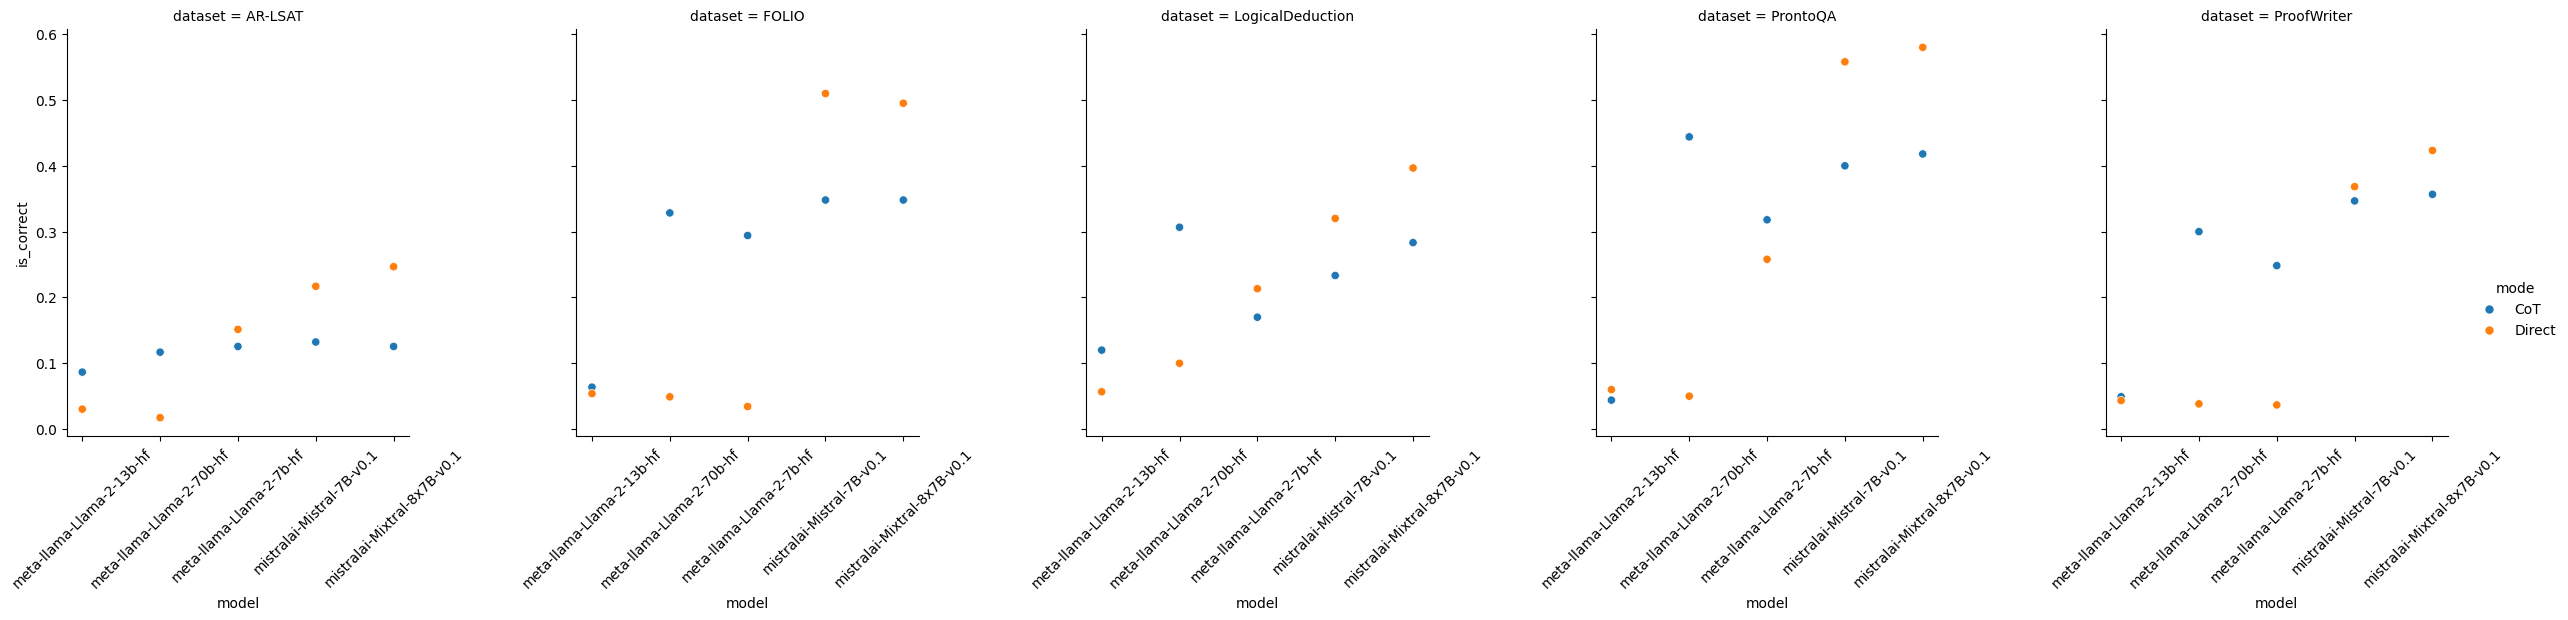

In [7]:
sns.relplot(data=df_all3,x="model",y="is_correct",col="dataset",hue="mode").tick_params(axis='x', rotation=45)

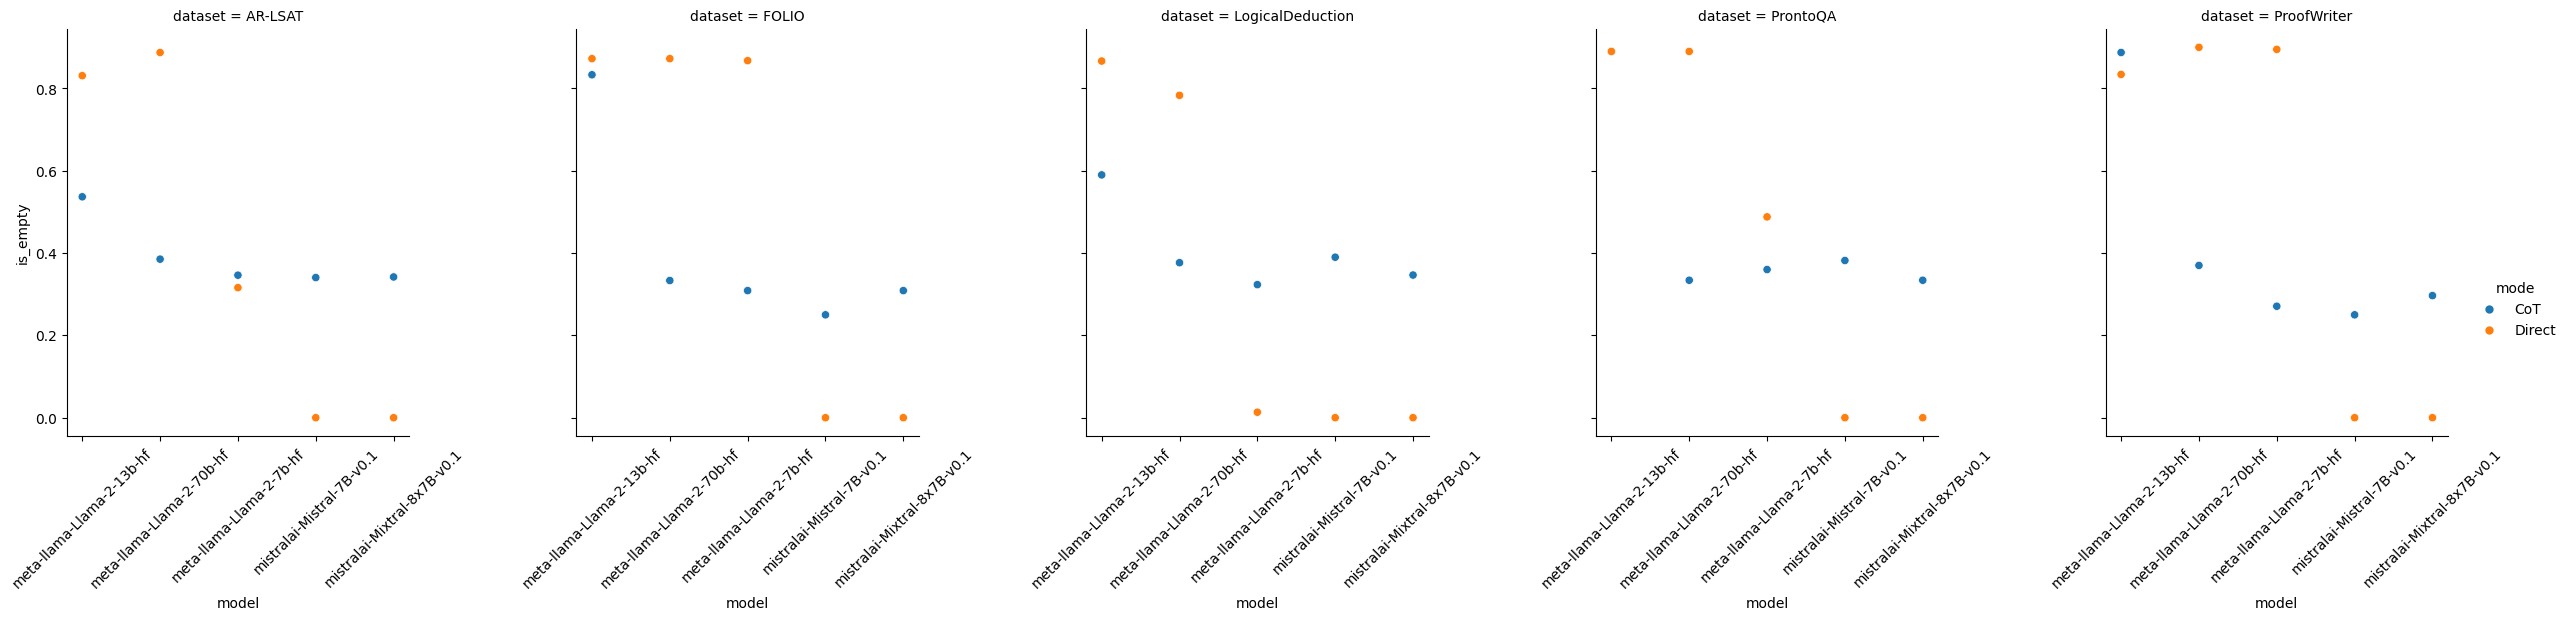

In [8]:
sns.relplot(data=df_all3,x="model",y="is_empty",col="dataset",hue="mode").tick_params(axis='x', rotation=45)

In [9]:
df_all4=df_all2.loc[df_all2.is_empty!=True,:].groupby(["model","dataset","mode"])[["is_correct","is_empty"]].mean().reset_index()

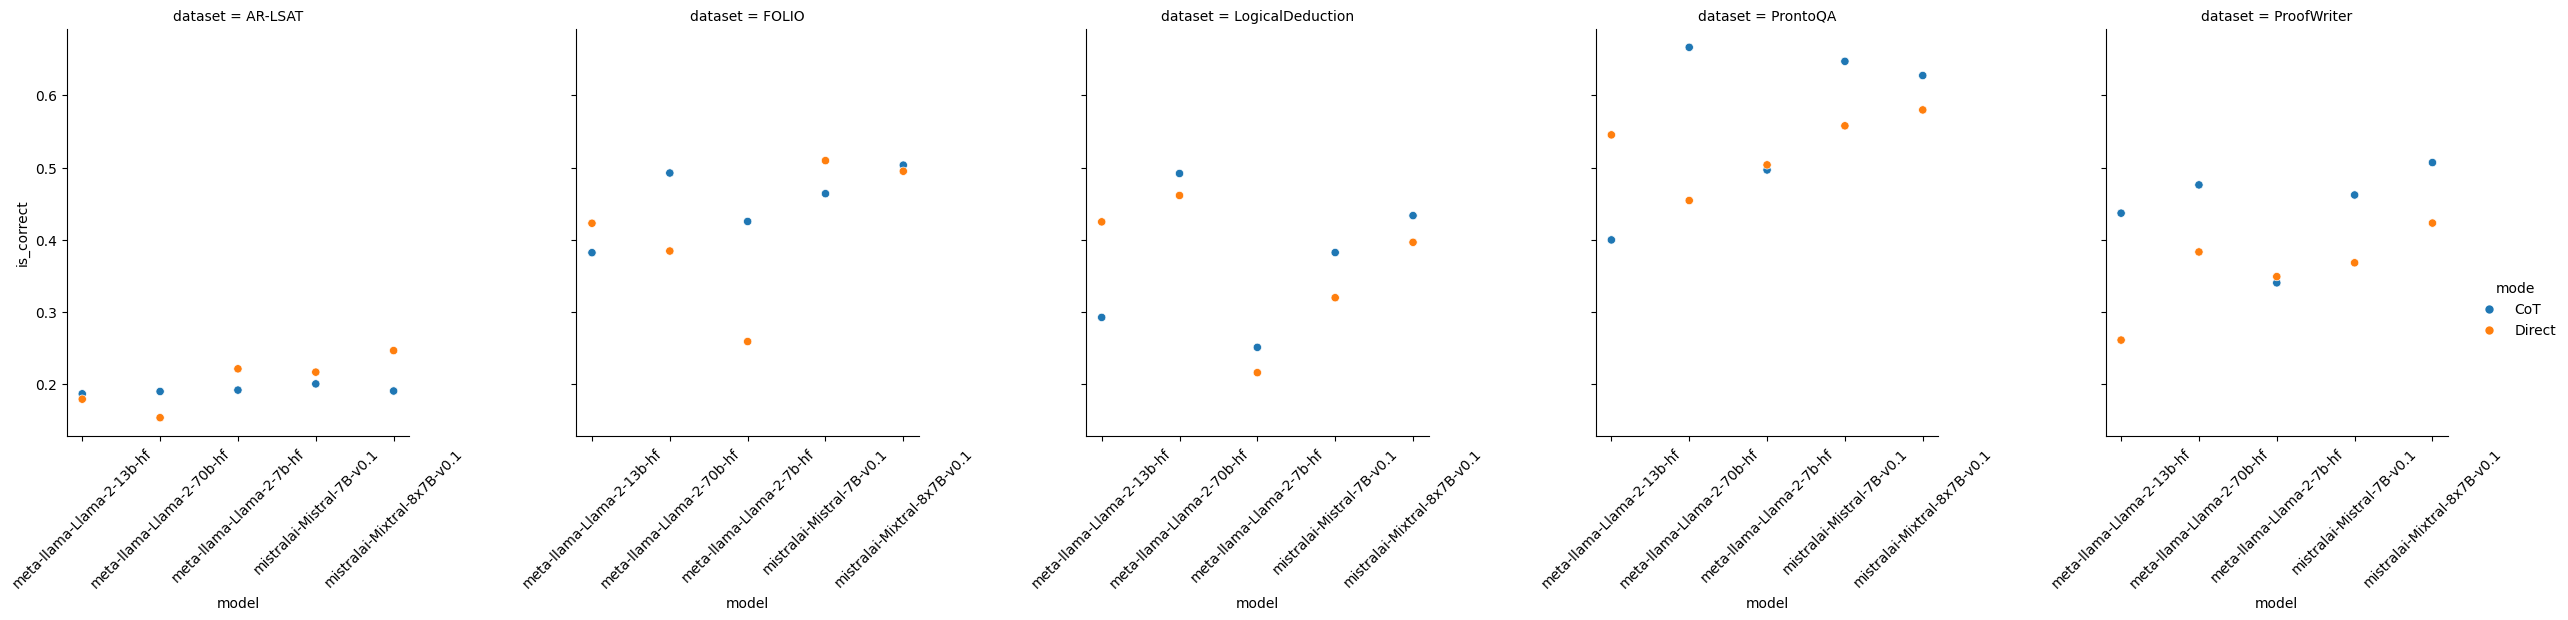

In [10]:
sns.relplot(data=df_all4,x="model",y="is_correct",col="dataset",hue="mode").tick_params(axis='x', rotation=45)

In [11]:
df_logic=[]
for file in os.listdir("./outputs/logic_inference"):
    if "mini_test" in file:
        continue

    if "minitest" in file:
        continue

    if "Bloke" in file:
        continue

    # if "backup-random" in file:
    #     continue

    if "checkpoint" in file:
        continue

    if 'self-refine' in file:
        refine, dataset, split, model, backup = file.split("_")
        refine = int(refine.split('-')[-1])
    else:
        dataset, split, model, backup = file.split("_")
        refine = 0
    
    result_file = os.path.join("./outputs/logic_inference",file)
    with open(result_file, 'r') as f:
        all_samples = json.load(f)
        f.close()
    df=pd.DataFrame(all_samples)
    if len(df) == 0:
        print(file)
        continue
    df["clean_answer"] = df.predicted_answer.apply(get_choice)
    df = df.drop(columns=["question", "predicted_answer","context"])
    df["answer"] = df.answer.str.replace('(', '').replace(')', '')
    df["is_correct"] = df.answer == df.clean_answer
    df["is_empty"] = df.clean_answer == ''
    df["mode"] = 'Logic'
    df["dataset"] = dataset
    df["split"] = split
    df["model"] = model
    df["refiment"] = refine
    df_logic.append(df)

AR-LSAT_dev_mistralai-Mistral-7B-v0.1-AR-LSAT-sft-best_backup-random.json


In [12]:
df_programs=[]
for file in os.listdir("./outputs/logic_programs"):
    if "mini_test" in file:
        continue

    if "minitest" in file:
        continue

    if "Bloke" in file:
        continue

    # if "backup-random" in file:
    #     continue

    if "checkpoint" in file:
        continue

    if 'self-refine' in file:
        refine, dataset, split, model = file.split("_")
        refine = int(refine.split('-')[-1])
    else:
        dataset, split, model = file.split("_")
        refine = 0
    
    result_file = os.path.join("./outputs/logic_programs",file)
    with open(result_file, 'r') as f:
        all_samples = json.load(f)
        f.close()

    df=pd.DataFrame(all_samples)
    if len(df) == 0:
        print(file)
        continue
    df["dataset"] = dataset
    df["split"] = split
    df["model"] = model[:-5]
    df["refiment"] = refine
    df_programs.append(df)

AR-LSAT_dev_mistralai-Mistral-7B-v0.1-AR-LSAT-sft-best.json
AR-LSAT_dev_mistralai-Mistral-7B-v0.1-AR-LSAT-sft-best-beam5.json


In [49]:
df_logic2=pd.concat(df_logic)

df_logic2["n_beam"]=df_logic2.groupby(["id","model","dataset","split","refiment"]).cumcount()

df_logic2 = df_logic2.loc[df_logic2["n_beam"] == 0]

df_total2 = pd.concat([df_all2,df_logic2])

df_total5 = df_total2.loc[(df_total2["mode"] == "Logic"),:]

fails = df_total5.loc[df_total5["flag"] != "success",:].groupby(["model","dataset","split","refiment"])[["flag"]].count()

total = df_total5.groupby(["model","dataset","split","refiment"])[["flag"]].count()

In [50]:
# df_total5.loc[(df_total5.dataset=="LogicalDeduction") & (df_total5.id=="logical_deduction_172"),:]

In [51]:
compilation_rate = (total-fails)/total

In [52]:
compilation_rate = compilation_rate.reset_index()

In [54]:
df_total6 = df_total5.loc[df_total5["flag"] == "success",:].groupby(["model","dataset","mode","split","refiment"])[["is_correct","is_empty"]].mean().reset_index()

In [55]:
df_total6

,model,dataset,mode,split,refiment,is_correct,is_empty
0,gpt-4,ProntoQA,Logic,dev,0,0.850962,0.000000
1,gpt-4,ProofWriter,Logic,dev,0,0.804408,0.000000
2,meta-llama-Llama-2-13b-hf,AR-LSAT,Logic,dev,0,0.272727,0.000000
3,meta-llama-Llama-2-13b-hf,AR-LSAT,Logic,dev,1,0.291667,0.000000
4,meta-llama-Llama-2-13b-hf,AR-LSAT,Logic,dev,2,0.291667,0.000000
...,...,...,...,...,...,...,...
108,mistralai-Mixtral-8x7B-v0.1,LogicalDeduction,Logic,dev,2,0.291946,0.647651
109,mistralai-Mixtral-8x7B-v0.1,LogicalDeduction,Logic,dev,3,0.291946,0.647651
110,mistralai-Mixtral-8x7B-v0.1,LogicalDeduction,Logic,train,0,0.602168,0.278565
111,mistralai-Mixtral-8x7B-v0.1,ProntoQA,Logic,dev,0,0.666667,0.000000


In [57]:
results_summary = pd.merge(compilation_rate,df_total6, how="left")

In [62]:
results_summary.loc[results_summary.model=="gpt-4"]

,model,dataset,split,refiment,compilation_rate,mode,is_correct,is_empty
1,gpt-4,ProntoQA,dev,0,0.416,Logic,0.850962,0.0
2,gpt-4,ProofWriter,dev,0,0.605,Logic,0.804408,0.0


In [68]:
results_summary.model.str.split('sft-best')

0        [HuggingFaceTB-SmolLM-135M]
1                            [gpt-4]
2                            [gpt-4]
3        [meta-llama-Llama-2-13b-hf]
4        [meta-llama-Llama-2-13b-hf]
                   ...              
151    [mistralai-Mixtral-8x7B-v0.1]
152    [mistralai-Mixtral-8x7B-v0.1]
153    [mistralai-Mixtral-8x7B-v0.1]
154    [mistralai-Mixtral-8x7B-v0.1]
155    [mistralai-Mixtral-8x7B-v0.1]
Name: model, Length: 156, dtype: object

In [75]:
def extract_base_model(model_name):
    datasets = ['AR-LSAT', 'ProntoQA', 'ProofWriter', 'FOLIO', 'LogicalDeduction']
    
    for dataset in datasets:
        if dataset in model_name:
            return model_name.split(dataset)[0].strip('-')
    
    return model_name  # Return original if no match found

# Apply the function to create a new column
results_summary['base_model'] = results_summary['model'].apply(extract_base_model)

In [80]:
results_summary['is_tuned'] = results_summary['model'].str.contains('sft-best')
results_summary['is_ppo'] = results_summary['model'].str.contains('ppo')
results_summary['is_beam'] = results_summary['model'].str.contains('beam')

In [81]:
results_summary = results_summary.rename(columns={"flag":"compilation_rate"})

In [82]:
results_summary["is_correct"] = results_summary.is_correct.fillna(0)
results_summary["is_empty"] = results_summary.is_empty.fillna(0)
results_summary["compilation_rate"] = results_summary.compilation_rate.fillna(1)
results_summary["mode"] = results_summary["mode"].fillna("Logic")

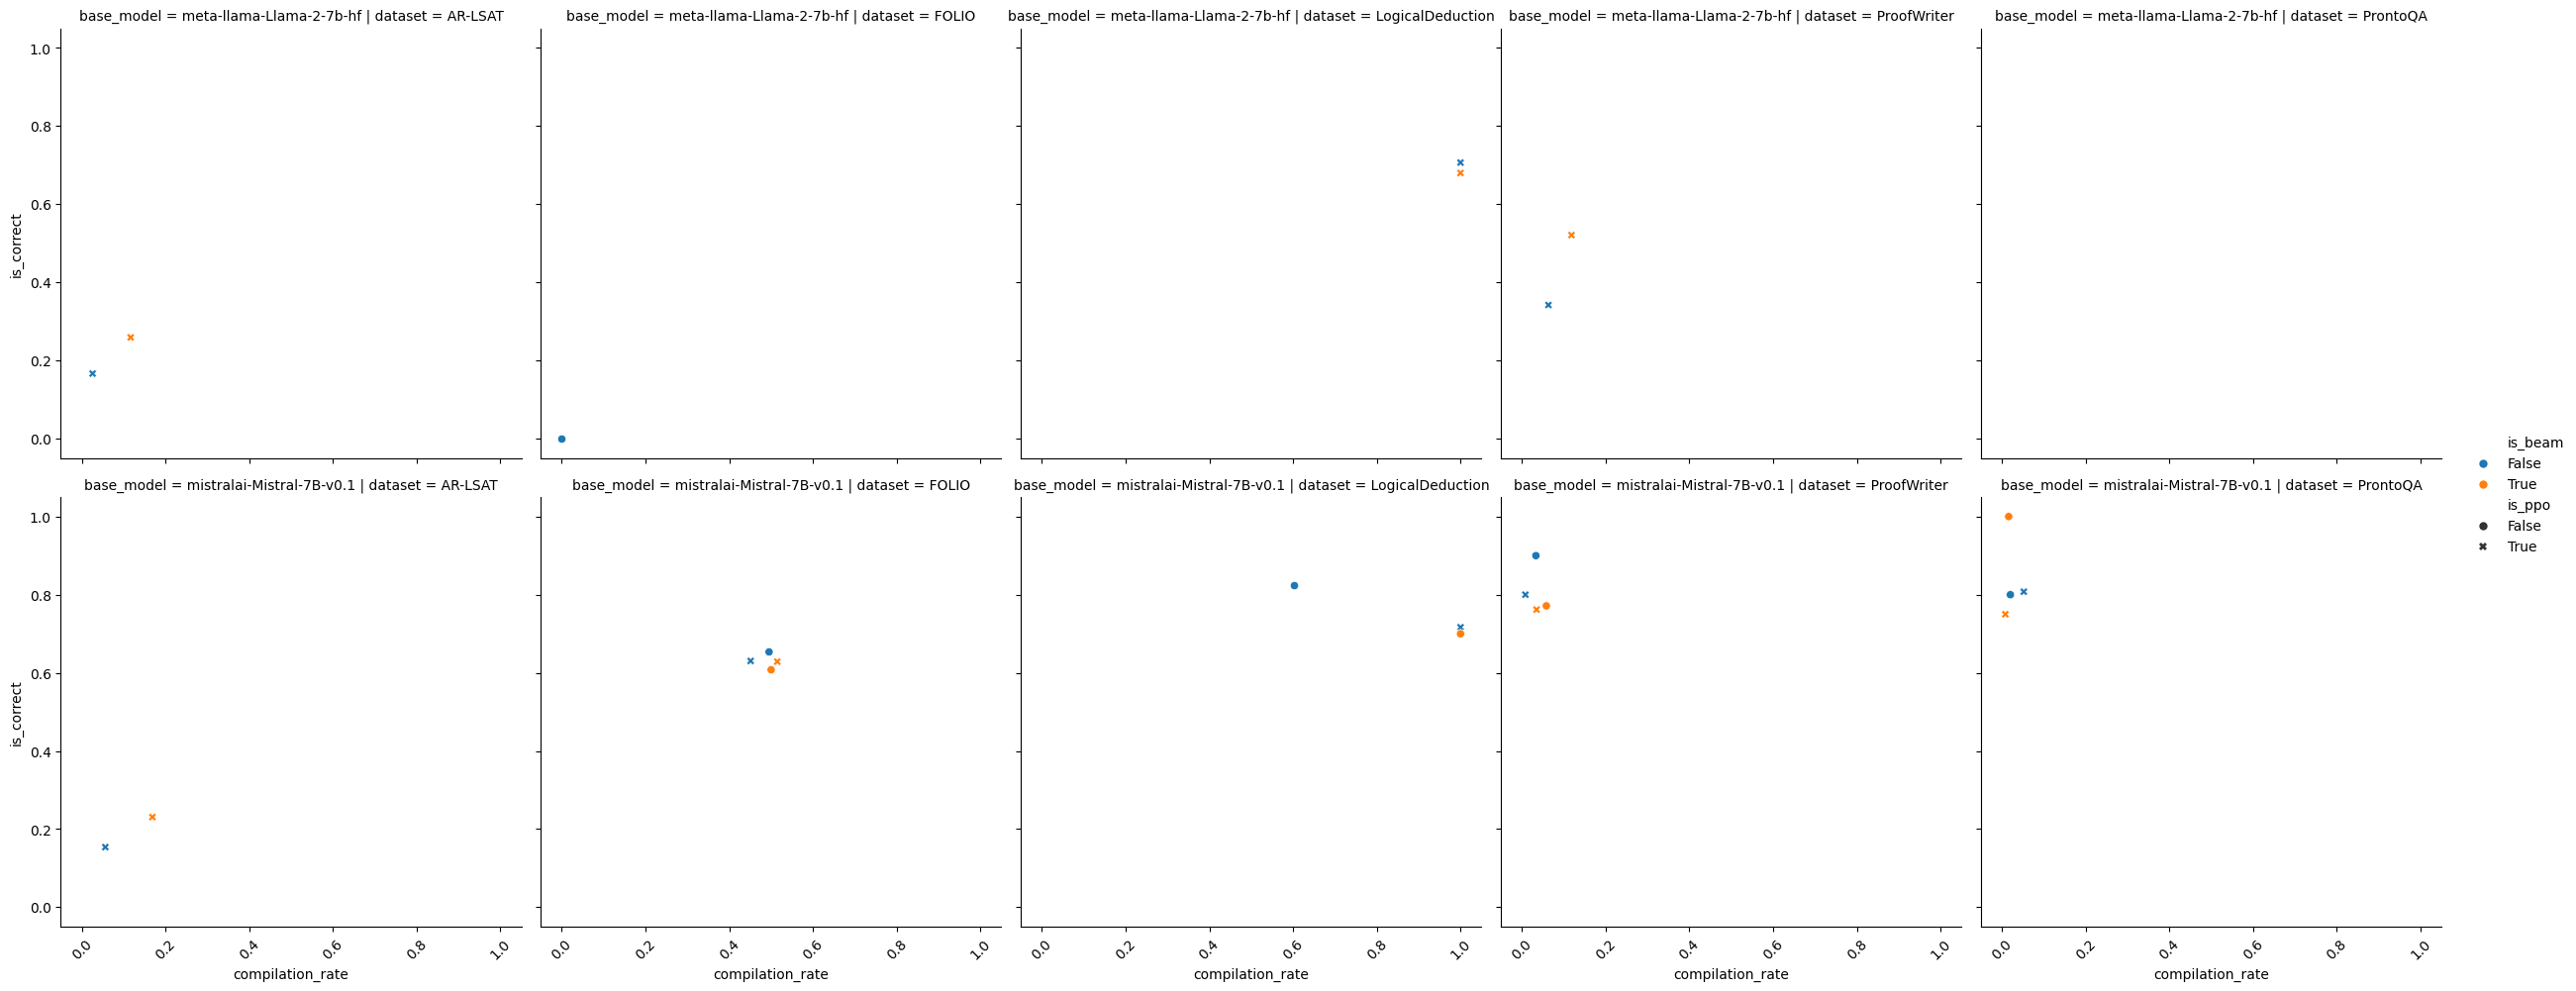

In [88]:
sns.relplot(data=results_summary.loc[(results_summary.split=="dev") & (results_summary.is_tuned==True)],x="compilation_rate",y="is_correct",col="dataset",row="base_model",hue="is_beam",style="is_ppo").tick_params(axis='x', rotation=45)

In [35]:
print(results_summary.to_string())

                                                                                   model           dataset  split  refiment  compilation_rate   mode  is_correct  is_empty
0                                                              HuggingFaceTB-SmolLM-135M           AR-LSAT    dev         0          0.000000    NaN         NaN       NaN
1                                                                                  gpt-4          ProntoQA    dev         0          0.416000  Logic    0.850962  0.000000
2                                                                                  gpt-4       ProofWriter    dev         0          0.605000  Logic    0.804408  0.000000
3                                                              meta-llama-Llama-2-13b-hf           AR-LSAT    dev         0          0.095238  Logic    0.272727  0.000000
4                                                              meta-llama-Llama-2-13b-hf           AR-LSAT    dev         1          0.103896  Lo

In [ ]:
df_total3=df_total2.groupby(["model","dataset","mode"])[["is_correct","is_empty"]].mean().reset_index()

In [ ]:
sns.relplot(data=df_total3,x="model",y="is_correct",col="dataset",hue="mode").tick_params(axis='x', rotation=45)

In [ ]:
sns.relplot(data=df_total3,x="model",y="is_empty",col="dataset",hue="mode").tick_params(axis='x', rotation=45)

In [ ]:
df_total4=df_total2.loc[df_total2.is_empty!=True,:].groupby(["model","dataset","mode"])[["is_correct","is_empty"]].mean().reset_index()

In [ ]:
sns.relplot(data=df_total4,x="model",y="is_correct",col="dataset",hue="mode").tick_params(axis='x', rotation=45)

In [ ]:
df_total4

In [69]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [30]:
df_total3

,model,dataset,mode,is_correct,is_empty
0,meta-llama-Llama-2-13b-hf,AR-LSAT,CoT,0.086580,0.536797
1,meta-llama-Llama-2-13b-hf,AR-LSAT,Direct,0.030303,0.831169
2,meta-llama-Llama-2-13b-hf,FOLIO,CoT,0.063725,0.833333
3,meta-llama-Llama-2-13b-hf,FOLIO,Direct,0.053922,0.872549
4,meta-llama-Llama-2-13b-hf,LogicalDeduction,CoT,0.120000,0.590000
5,meta-llama-Llama-2-13b-hf,LogicalDeduction,Direct,0.056667,0.866667
6,meta-llama-Llama-2-13b-hf,ProntoQA,CoT,0.044000,0.890000
7,meta-llama-Llama-2-13b-hf,ProntoQA,Direct,0.060000,0.890000
8,meta-llama-Llama-2-13b-hf,ProofWriter,CoT,0.049167,0.887500
9,meta-llama-Llama-2-13b-hf,ProofWriter,Direct,0.043333,0.834167


In [31]:
print(df_total3.to_string())

                                             model           dataset    mode  is_correct  is_empty
0                        meta-llama-Llama-2-13b-hf           AR-LSAT     CoT    0.086580  0.536797
1                        meta-llama-Llama-2-13b-hf           AR-LSAT  Direct    0.030303  0.831169
2                        meta-llama-Llama-2-13b-hf             FOLIO     CoT    0.063725  0.833333
3                        meta-llama-Llama-2-13b-hf             FOLIO  Direct    0.053922  0.872549
4                        meta-llama-Llama-2-13b-hf  LogicalDeduction     CoT    0.120000  0.590000
5                        meta-llama-Llama-2-13b-hf  LogicalDeduction  Direct    0.056667  0.866667
6                        meta-llama-Llama-2-13b-hf          ProntoQA     CoT    0.044000  0.890000
7                        meta-llama-Llama-2-13b-hf          ProntoQA  Direct    0.060000  0.890000
8                        meta-llama-Llama-2-13b-hf       ProofWriter     CoT    0.049167  0.887500
9         

In [34]:
import traceback
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Extraction function
def tflog2pandas(path):
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data


In [35]:
path="/mnt/evafs/groups/luckner-lab/models/mistralai/Mistral-7B-v0.1/LogicalDeduction/sft/runs/Jun11_22-53-05_dgx-4.eden" #folderpath
df=tflog2pandas(path)

In [36]:
df.metric.unique()

array(['train/loss', 'train/grad_norm', 'train/learning_rate',
       'train/epoch', 'eval/loss', 'eval/runtime',
       'eval/samples_per_second', 'eval/steps_per_second',
       'train/train_runtime', 'train/train_samples_per_second',
       'train/train_steps_per_second', 'train/total_flos',
       'train/train_loss'], dtype=object)

In [37]:
df

,metric,value,step
0,train/loss,3.482000e-01,10.0
1,train/loss,9.910000e-02,20.0
2,train/loss,5.540000e-02,30.0
3,train/loss,4.700000e-02,40.0
4,train/loss,4.270000e-02,50.0
...,...,...,...
0,train/train_runtime,7.297424e+02,396.0
0,train/train_samples_per_second,2.168000e+00,396.0
0,train/train_steps_per_second,5.430000e-01,396.0
0,train/total_flos,1.106620e+17,396.0


In [38]:
# sns.lineplot(data=df.loc[df.metric=="eval/loss",:],x="step",y="value").set(ylabel="Train Loss", title="LogicalDeduction")

[Text(0, 0.5, 'Train Loss'), Text(0.5, 1.0, 'LogicalDeduction')]

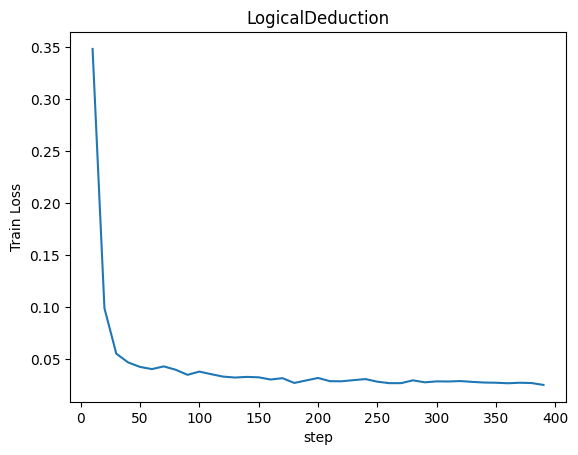

In [39]:
sns.lineplot(data=df.loc[df.metric=="train/loss",:],x="step",y="value").set(ylabel="Train Loss", title="LogicalDeduction")

In [38]:
# sns.relplot(data=df,x="step",y="value",row="metric",kind="line")

In [39]:
df.loc[df.metric=="ppo/policy/ratio",:]

,metric,value,step


<Axes: xlabel='step', ylabel='value'>

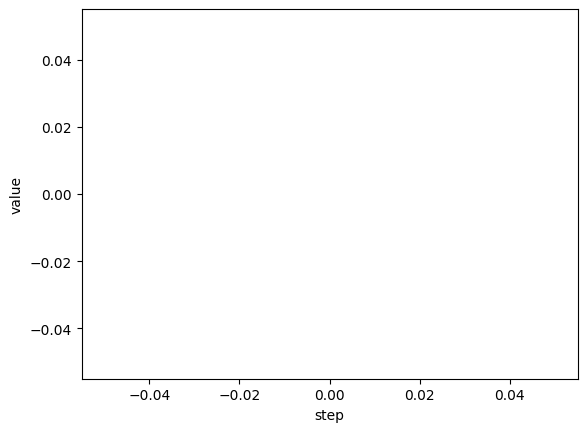

In [40]:
sns.lineplot(data=df.loc[df.metric=="objective/kl",:],x="step",y="value")

In [41]:
bool(0)

False

<Axes: xlabel='step', ylabel='value'>

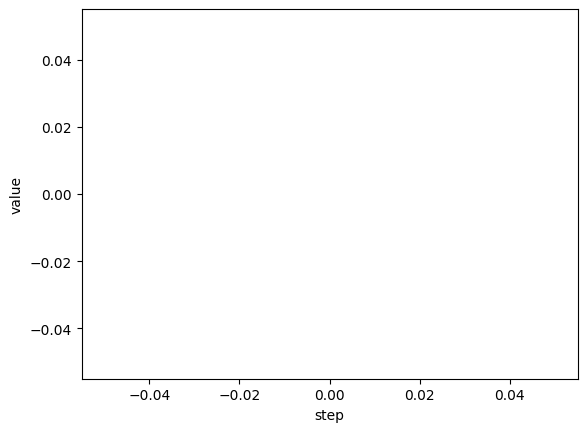

In [42]:
sns.lineplot(data=df.loc[df.metric=="ppo/policy/approxkl",:],x="step",y="value")

<Axes: xlabel='step', ylabel='value'>

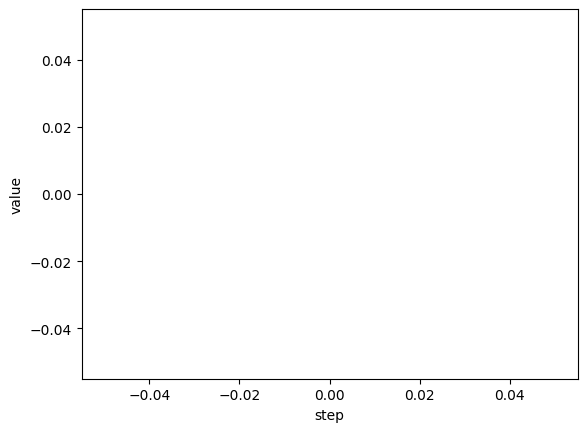

In [43]:
sns.lineplot(data=df.loc[df.metric=="ppo/policy/loss",:],x="step",y="value")

<Axes: xlabel='step', ylabel='value'>

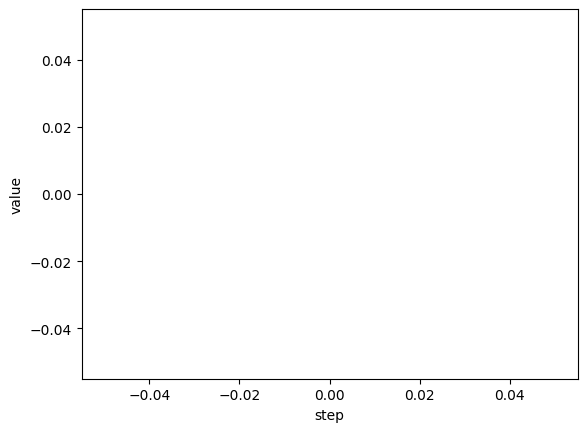

In [44]:
sns.lineplot(data=df.loc[df.metric=="ppo/policy/approxkl",:],x="step",y="value")

In [45]:
df.loc[df.metric=="env/reward_mean",:]

,metric,value,step


<Axes: xlabel='step', ylabel='value'>

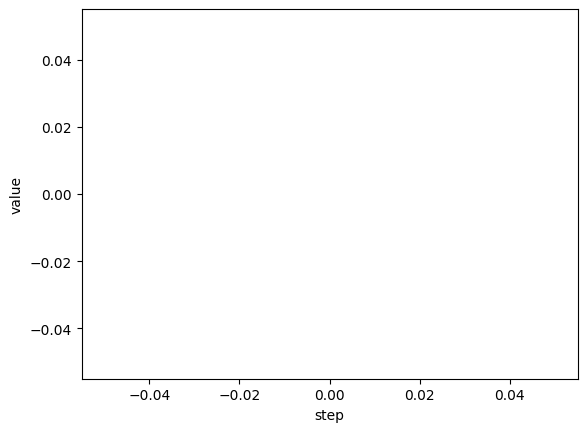

In [46]:
sns.lineplot(data=df.loc[df.metric=="env/reward_mean",:],x="step",y="value")